In [1]:
%load_ext autoreload
%autoreload 2

import cartopy.crs as ccrs
import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from fme_diags.time_mean import plot_time_mean, plot_time_mean_bias, plot_time_mean_bias_list
from fme_diags.utils import (
    get_run_kwargs, load_config, 
    open_autoregressive_inference,
)

_ = xr.set_options(keep_attrs=True)

In [2]:
RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"

OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"
PRECIP = "surface_precipitation_rate"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"
FLUX_UNITS = "W/m$^2$"

DATADIR = f"../data/{RUN_KEY}"
assert os.path.isdir(DATADIR), f"{DATADIR} doesn't exist."

E3SM_DIAGS_NCS = {
    "FSNTOA_CERES": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-FSNTOA-ANN-global_ref.nc"),
    "FSNTOA_E3SM": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-FSNTOA-ANN-global_test-target.nc"),
    "FSNTOA_ACE": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-FSNTOA-ANN-global_test-prediction.nc"),
    "SOLIN_CERES": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-SOLIN-ANN-global_ref.nc"),
    "SOLIN_E3SM": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-SOLIN-ANN-global_test-target.nc"),
    "SOLIN_ACE": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-SOLIN-ANN-global_test-prediction.nc"),
    "FLUT_TAR_DIFF": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-FLUT-ANN-global_diff-target.nc"),
    "FLUT_PRED_DIFF": os.path.join(DATADIR, "ceres_ebaf_toa_v4.1-FLUT-ANN-global_diff-prediction.nc"),
    "PRECIP_TAR_DIFF": os.path.join(DATADIR, "GPCP_v3.2-PRECT-ANN-global_diff-target.nc"),
    "PRECIP_PRED_DIFF": os.path.join(DATADIR, "GPCP_v3.2-PRECT-ANN-global_diff-prediction.nc"),
}

E3SM_DIAGS_DATA_VARS = {
    "FSNTOA_CERES": "FSNTOA",
    "FSNTOA_E3SM": "FSNTOA",
    "FSNTOA_ACE": "FSNTOA",
    "SOLIN_CERES": "rsdt",
    "SOLIN_E3SM": "SOLIN",
    "SOLIN_ACE": "SOLIN",
    "FLUT_TAR_DIFF": "FLUT_diff",
    "FLUT_PRED_DIFF": "FLUT_diff",
    "PRECIP_TAR_DIFF": "PRECT_diff",
    "PRECIP_PRED_DIFF": "PRECT_diff",
}

for nc in E3SM_DIAGS_NCS.values():
    assert os.path.isfile(nc), f"{nc} doesn't exist; please add it first."

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
FIG_PREFIX = "obs-biases"
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 -89.24 ... 8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    OCNFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    top_of_atmos_upward_shortwave_flux             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path_due_to_advection  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_1                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_0                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FLDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ICEFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
with ProgressBar():
    da_OSR_mean = ds[OSR].mean("time").compute()
    
da_OSR_e3sm_mean = da_OSR_mean.sel(source="target")
da_OSR_ace_mean = da_OSR_mean.sel(source="prediction")

da_OSR_sim_diff = da_OSR_ace_mean - da_OSR_e3sm_mean

[########################################] | 100% Completed | 38.2s


In [7]:
def open_diags_nc(path, varname, lat_coords):
    da = xr.open_dataset(path)[varname]
    da["lat"] = lat_coords
    return da

diags_das = { k: open_diags_nc(path, E3SM_DIAGS_DATA_VARS[k], ds["lat"]) for k, path in E3SM_DIAGS_NCS.items() }

time_mean_bias min: -22.50527954
time_mean_bias max: 21.39744568
baseline_time_mean_bias min: -77.92678833
baseline_time_mean_bias max: 55.43812561


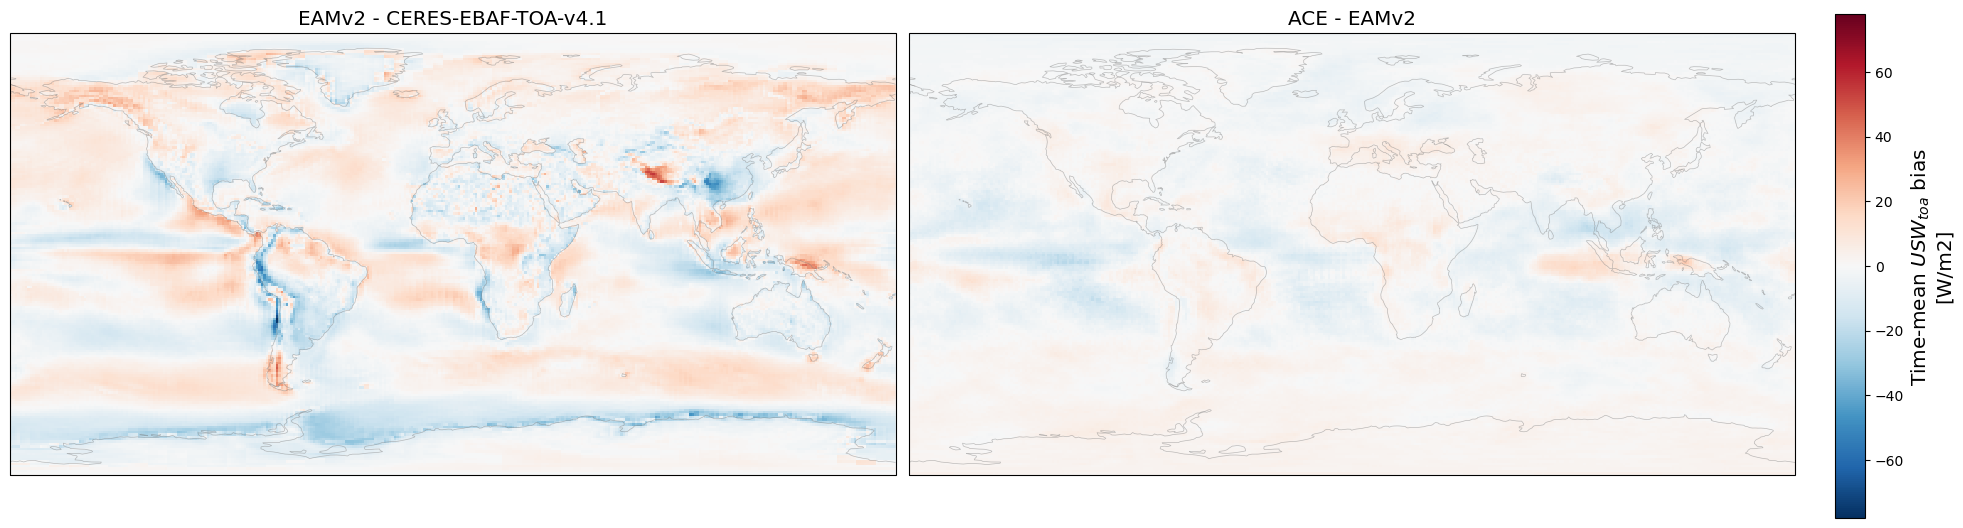

In [8]:
da_OSR_ceres = (diags_das["SOLIN_CERES"] - diags_das["FSNTOA_CERES"]).assign_attrs(units=FLUX_UNITS)
da_OSR_e3sm = (diags_das["SOLIN_E3SM"] - diags_das["FSNTOA_E3SM"]).assign_attrs(units=FLUX_UNITS)

da_OSR_e3sm_diff = da_OSR_e3sm - da_OSR_ceres

fig, axs = plot_time_mean_bias(
    da_OSR_sim_diff,
    da_OSR_e3sm_diff,
    var_name="$USW_{toa}$",
    verbose=True,
)

axs[0].set_title("EAMv2 - CERES-EBAF-TOA-v4.1", fontsize="x-large")
axs[1].set_title("ACE - EAMv2", fontsize="x-large")

fig.show()

In [9]:
with ProgressBar():
    da_OLR_mean = ds[OLR].mean("time").compute()
    
da_OLR_e3sm_mean = da_OLR_mean.sel(source="target")
da_OLR_ace_mean = da_OLR_mean.sel(source="prediction")

da_OLR_sim_diff = da_OLR_ace_mean - da_OLR_e3sm_mean
da_OLR_e3sm_diff = diags_das["FLUT_TAR_DIFF"].assign_attrs(units=FLUX_UNITS)

[########################################] | 100% Completed | 37.0s


time_mean_bias min: -14.83920288
time_mean_bias max: 12.24757385
baseline_time_mean_bias min: -27.12939453
baseline_time_mean_bias max: 33.08580017


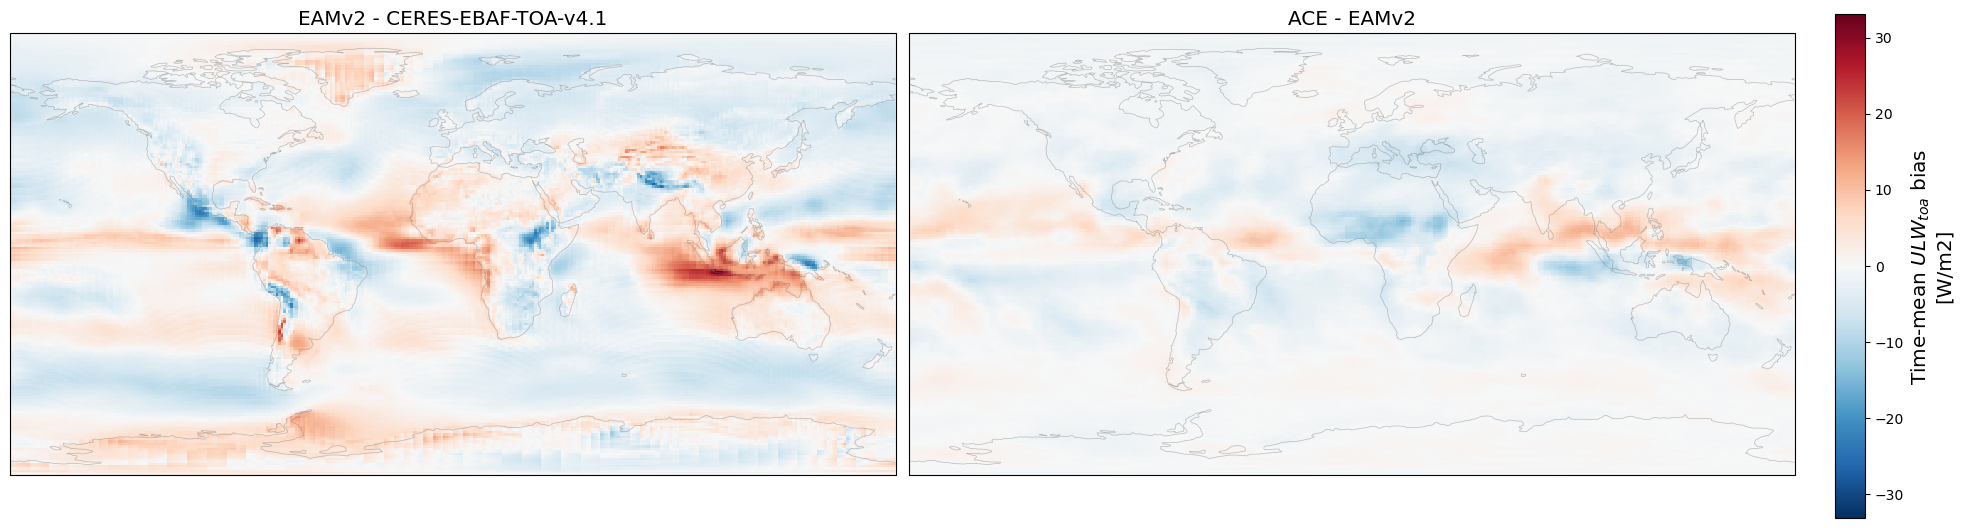

In [10]:
fig, axs = plot_time_mean_bias(
    da_OLR_sim_diff,
    da_OLR_e3sm_diff,
    var_name="$ULW_{toa}$",
    verbose=True,
)

axs[0].set_title("EAMv2 - CERES-EBAF-TOA-v4.1", fontsize="x-large")
axs[1].set_title("ACE - EAMv2", fontsize="x-large")

fig.show()

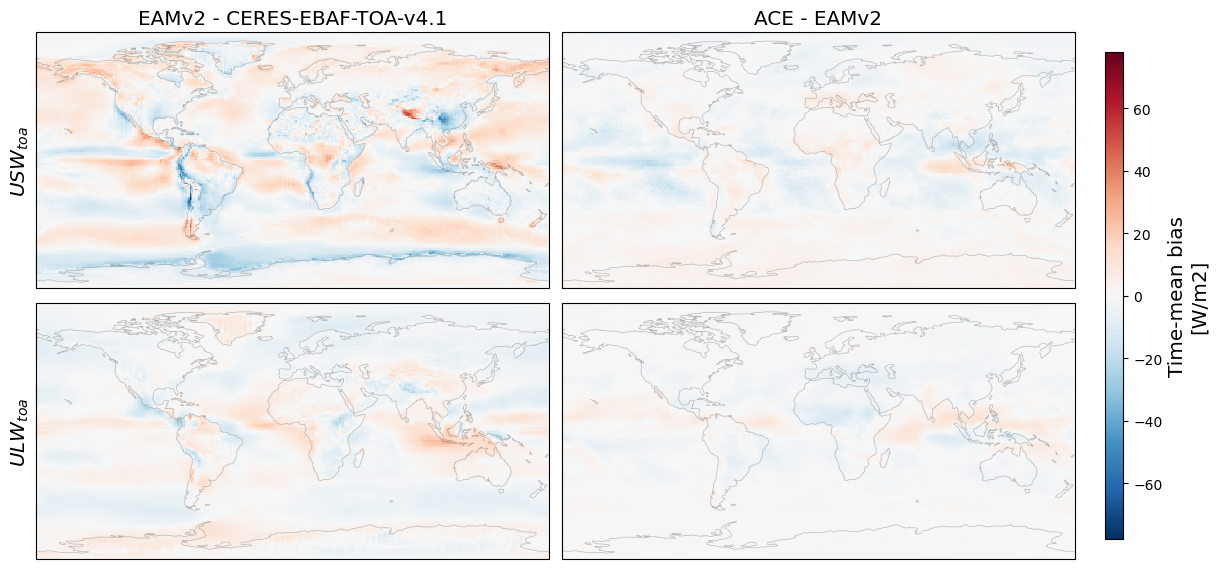

In [11]:
fig, axs = plot_time_mean_bias_list(
    [da_OSR_sim_diff, da_OLR_sim_diff], 
    [da_OSR_e3sm_diff, da_OLR_e3sm_diff],
    var_names=["$USW_{toa}$", "$ULW_{toa}$"],
    figsize=(12, 5.8),
    vmax_abs=np.abs(da_OSR_e3sm_diff).max(),
)

axs[0, 0].set_title("EAMv2 - CERES-EBAF-TOA-v4.1", fontsize="x-large")
axs[0, 1].set_title("ACE - EAMv2", fontsize="x-large")

fig.show()

In [12]:
with ProgressBar():
    da_precip_mean = ds[PRECIP].mean("time").compute()
    
da_precip_mean = PRECIP_FACTOR * da_precip_mean.assign_attrs(units=PRECIP_UNITS)
    
da_precip_e3sm_mean = da_precip_mean.sel(source="target")
da_precip_ace_mean = da_precip_mean.sel(source="prediction")

da_precip_sim_diff = da_precip_ace_mean - da_precip_e3sm_mean
da_precip_e3sm_diff = diags_das["PRECIP_TAR_DIFF"].assign_attrs(units=PRECIP_UNITS)

[########################################] | 100% Completed | 38.2s


time_mean_bias min: -2.46666479
time_mean_bias max: 3.70119095
baseline_time_mean_bias min: -6.50824165
baseline_time_mean_bias max: 12.60898781


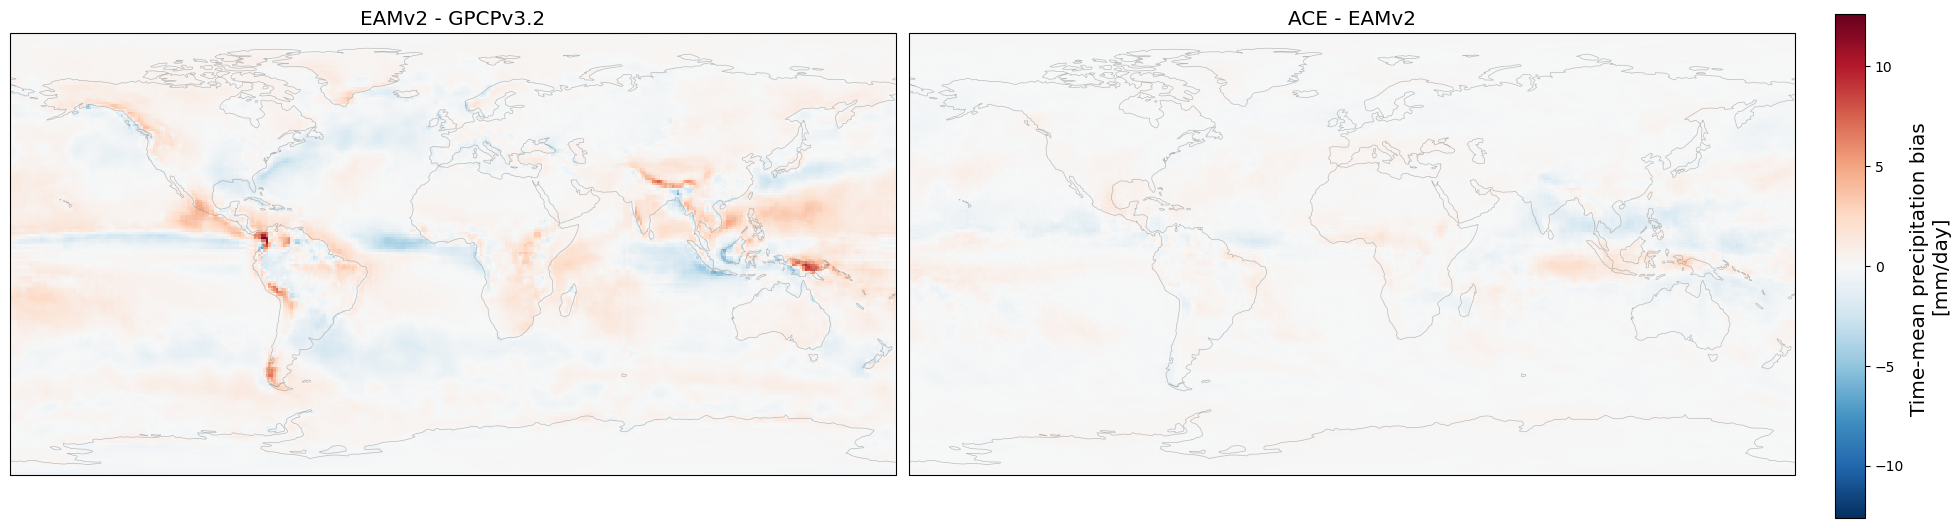

In [13]:
fig, axs = plot_time_mean_bias(
    da_precip_sim_diff,
    da_precip_e3sm_diff,
    var_name="precipitation",
    verbose=True,
)

axs[0].set_title("EAMv2 - GPCPv3.2", fontsize="x-large")
axs[1].set_title("ACE - EAMv2", fontsize="x-large")

fig.show()

time_mean[i], $P$ bias, (min, max): -2.46666479, 3.70119095
time_mean[i], $P$ bias, area-weighted mean: 0.00566156
time_mean[i], $P$ bias, area-weighted RMSE: 0.37402788
baseline_time_mean[i], $P$ bias (min, max): -6.50824165, 12.60898781
baseline_time_mean[i], $P$ bias, area-weighted mean: 0.19757397
baseline_time_mean[i], $P$ bias, area-weighted RMSE: 0.96226418
time_mean[i], $USW_{toa}$ bias, (min, max): -22.50527954, 21.39744568
time_mean[i], $USW_{toa}$ bias, area-weighted mean: -0.94787198
time_mean[i], $USW_{toa}$ bias, area-weighted RMSE: 4.17011833
baseline_time_mean[i], $USW_{toa}$ bias (min, max): -77.92678833, 55.43812561
baseline_time_mean[i], $USW_{toa}$ bias, area-weighted mean: 0.57169675
baseline_time_mean[i], $USW_{toa}$ bias, area-weighted RMSE: 9.18759924
time_mean[i], $ULW_{toa}$ bias, (min, max): -14.83920288, 12.24757385
time_mean[i], $ULW_{toa}$ bias, area-weighted mean: -0.59279090
time_mean[i], $ULW_{toa}$ bias, area-weighted RMSE: 2.82810224
baseline_time_mea

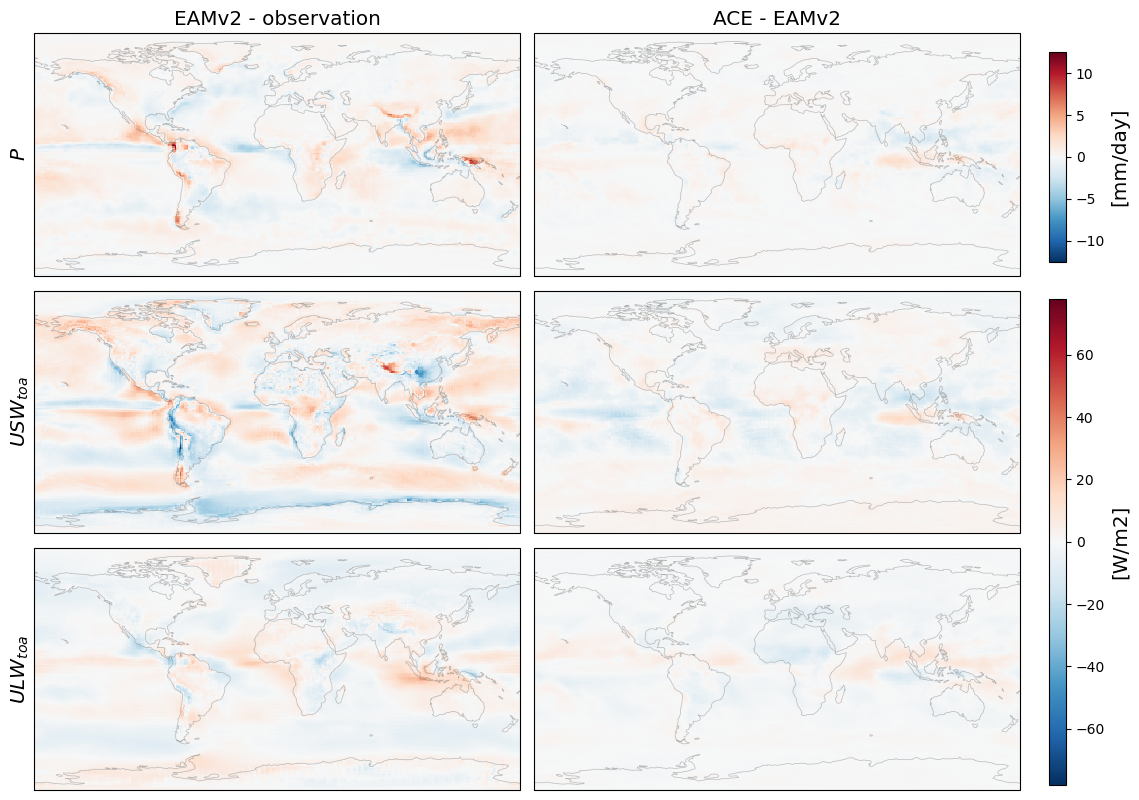

In [14]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(11.5, 8.1),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

im_precip = plot_time_mean_bias_list(
    [da_precip_sim_diff],
    [da_precip_e3sm_diff],
    var_names=["$P$"],
    vmax_abs=np.abs(da_precip_e3sm_diff).max(),
    axs=axs[0:1],
    verbose=True,
)

im_fluxes = plot_time_mean_bias_list(
    [da_OSR_sim_diff, da_OLR_sim_diff], 
    [da_OSR_e3sm_diff, da_OLR_e3sm_diff],
    var_names=["$USW_{toa}$", "$ULW_{toa}$"],
    vmax_abs=np.abs(da_OSR_e3sm_diff).max(),
    axs=axs[1:],
    verbose=True,
)

axs[0][0].set_title("EAMv2 - observation", fontsize="x-large")
axs[0][1].set_title("ACE - EAMv2", fontsize="x-large")

axs[1][0].set_title("")
axs[1][1].set_title("")

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.91, 0.67, 0.015, 0.26])
cbar = fig.colorbar(
    im_precip,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{da_precip_sim_diff.units}]", fontsize="x-large"
)

cbar_ax = fig.add_axes([0.91, 0.025, 0.015, 0.6])
cbar = fig.colorbar(
    im_fluxes,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{da_OSR_sim_diff.units}]", fontsize="x-large"
)

fig.show()

In [15]:
fig.savefig(os.path.join(OUTDIR, "obs_biases.pdf"), bbox_inches="tight")

In [16]:
da_OSR_ace = (diags_das["SOLIN_ACE"] - diags_das["FSNTOA_ACE"]).assign_attrs(units=FLUX_UNITS)
da_OSR_ace_diff = da_OSR_ace - da_OSR_ceres

da_OLR_ace_diff = diags_das["FLUT_PRED_DIFF"].assign_attrs(units=FLUX_UNITS)

da_precip_ace_diff = diags_das["PRECIP_PRED_DIFF"].assign_attrs(units=PRECIP_UNITS)

time_mean[i], $P$ bias, (min, max): -6.65913486, 13.12002945
time_mean[i], $P$ bias, area-weighted mean: 0.20324127
time_mean[i], $P$ bias, area-weighted RMSE: 0.93195449
baseline_time_mean[i], $P$ bias (min, max): -6.50824165, 12.60898781
baseline_time_mean[i], $P$ bias, area-weighted mean: 0.19757397
baseline_time_mean[i], $P$ bias, area-weighted RMSE: 0.96226418
time_mean[i], $USW_{toa}$ bias, (min, max): -78.50146484, 49.61250305
time_mean[i], $USW_{toa}$ bias, area-weighted mean: -0.37626796
time_mean[i], $USW_{toa}$ bias, area-weighted RMSE: 8.87458077
baseline_time_mean[i], $USW_{toa}$ bias (min, max): -77.92678833, 55.43812561
baseline_time_mean[i], $USW_{toa}$ bias, area-weighted mean: 0.57169675
baseline_time_mean[i], $USW_{toa}$ bias, area-weighted RMSE: 9.18759924
time_mean[i], $ULW_{toa}$ bias, (min, max): -33.79598999, 27.54574585
time_mean[i], $ULW_{toa}$ bias, area-weighted mean: -0.76588596
time_mean[i], $ULW_{toa}$ bias, area-weighted RMSE: 5.63991777
baseline_time_me

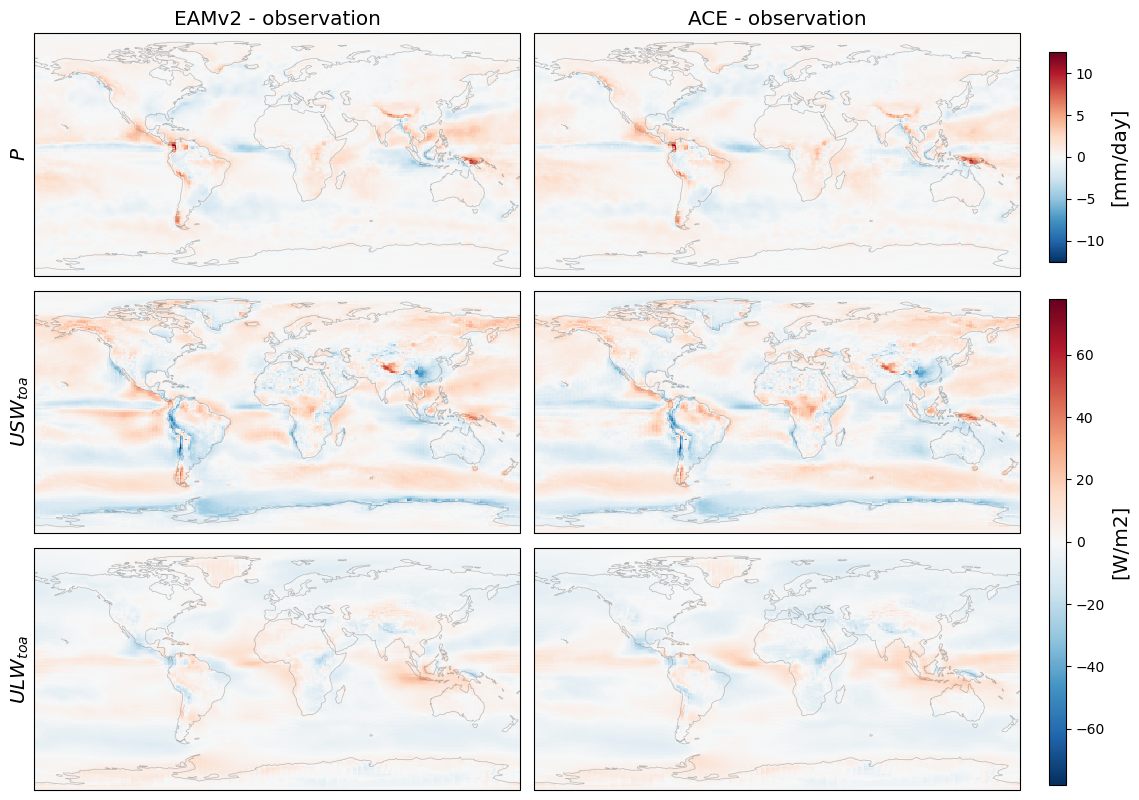

In [17]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(11.5, 8.1),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

im_precip = plot_time_mean_bias_list(
    [da_precip_ace_diff],
    [da_precip_e3sm_diff],
    var_names=["$P$"],
    vmax_abs=np.abs(da_precip_e3sm_diff).max(),
    axs=axs[0:1],
    verbose=True,
)

im_fluxes = plot_time_mean_bias_list(
    [da_OSR_ace_diff, da_OLR_ace_diff], 
    [da_OSR_e3sm_diff, da_OLR_e3sm_diff],
    var_names=["$USW_{toa}$", "$ULW_{toa}$"],
    vmax_abs=np.abs(da_OSR_e3sm_diff).max(),
    axs=axs[1:],
    verbose=True,
)

axs[0][0].set_title("EAMv2 - observation", fontsize="x-large")
axs[0][1].set_title("ACE - observation", fontsize="x-large")

axs[1][0].set_title("")
axs[1][1].set_title("")

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.91, 0.67, 0.015, 0.26])
cbar = fig.colorbar(
    im_precip,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{da_precip_sim_diff.units}]", fontsize="x-large"
)

cbar_ax = fig.add_axes([0.91, 0.025, 0.015, 0.6])
cbar = fig.colorbar(
    im_fluxes,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{da_OSR_sim_diff.units}]", fontsize="x-large"
)

fig.show()